In [1]:
# Autoreload 
%load_ext autoreload
%autoreload 2

device = 'cuda'

In [2]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

from utils import wav_to_kev

In [3]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

images = ['gogo', 'dionisios', 'fanourios', 'odigitria', 'minos', 'saintjohn']

band_range = range(0, 4096)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(band_range.start, band_range.stop), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

e = wav_to_kev(band_range)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [4]:
# list all .txt files in the directory 'home/igeor/data'
import os
import glob

# Get the list of all pure elements files
list_of_files = glob.glob('/home/igeor/MSC-THESIS/data/h5/pure/*.txt')
# Load all pure elements
pure_elements = {}
for file in list_of_files:
    # keep only the name of the element
    element = file.split('/')[-1].split('.')[0]
    pure_elements[element] = np.loadtxt(file)
# Normalize all pure elements
for element in pure_elements:
    pure_elements[element] = pure_elements[element] / np.max(pure_elements[element])

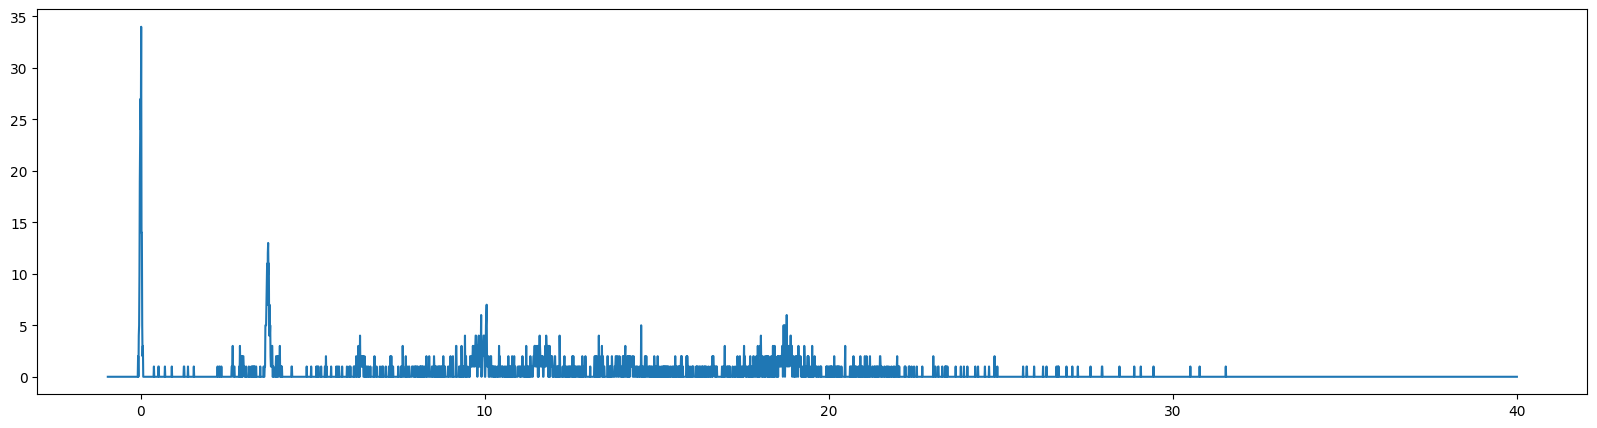

[('Ca_K', tensor(143.4820)), ('Hg_L', tensor(130.5490)), ('Au_L', tensor(116.6800)), ('Sr_K', tensor(36.8063)), ('Pb_L', tensor(35.0808)), ('Fe_K', tensor(28.4705)), ('Cu_K', tensor(11.4308)), ('Zn_K', tensor(8.0422)), ('K_K', tensor(5.5496)), ('Cr_K', tensor(5.0776)), ('S_K', tensor(2.5522)), ('Mn_K', tensor(1.4946))]


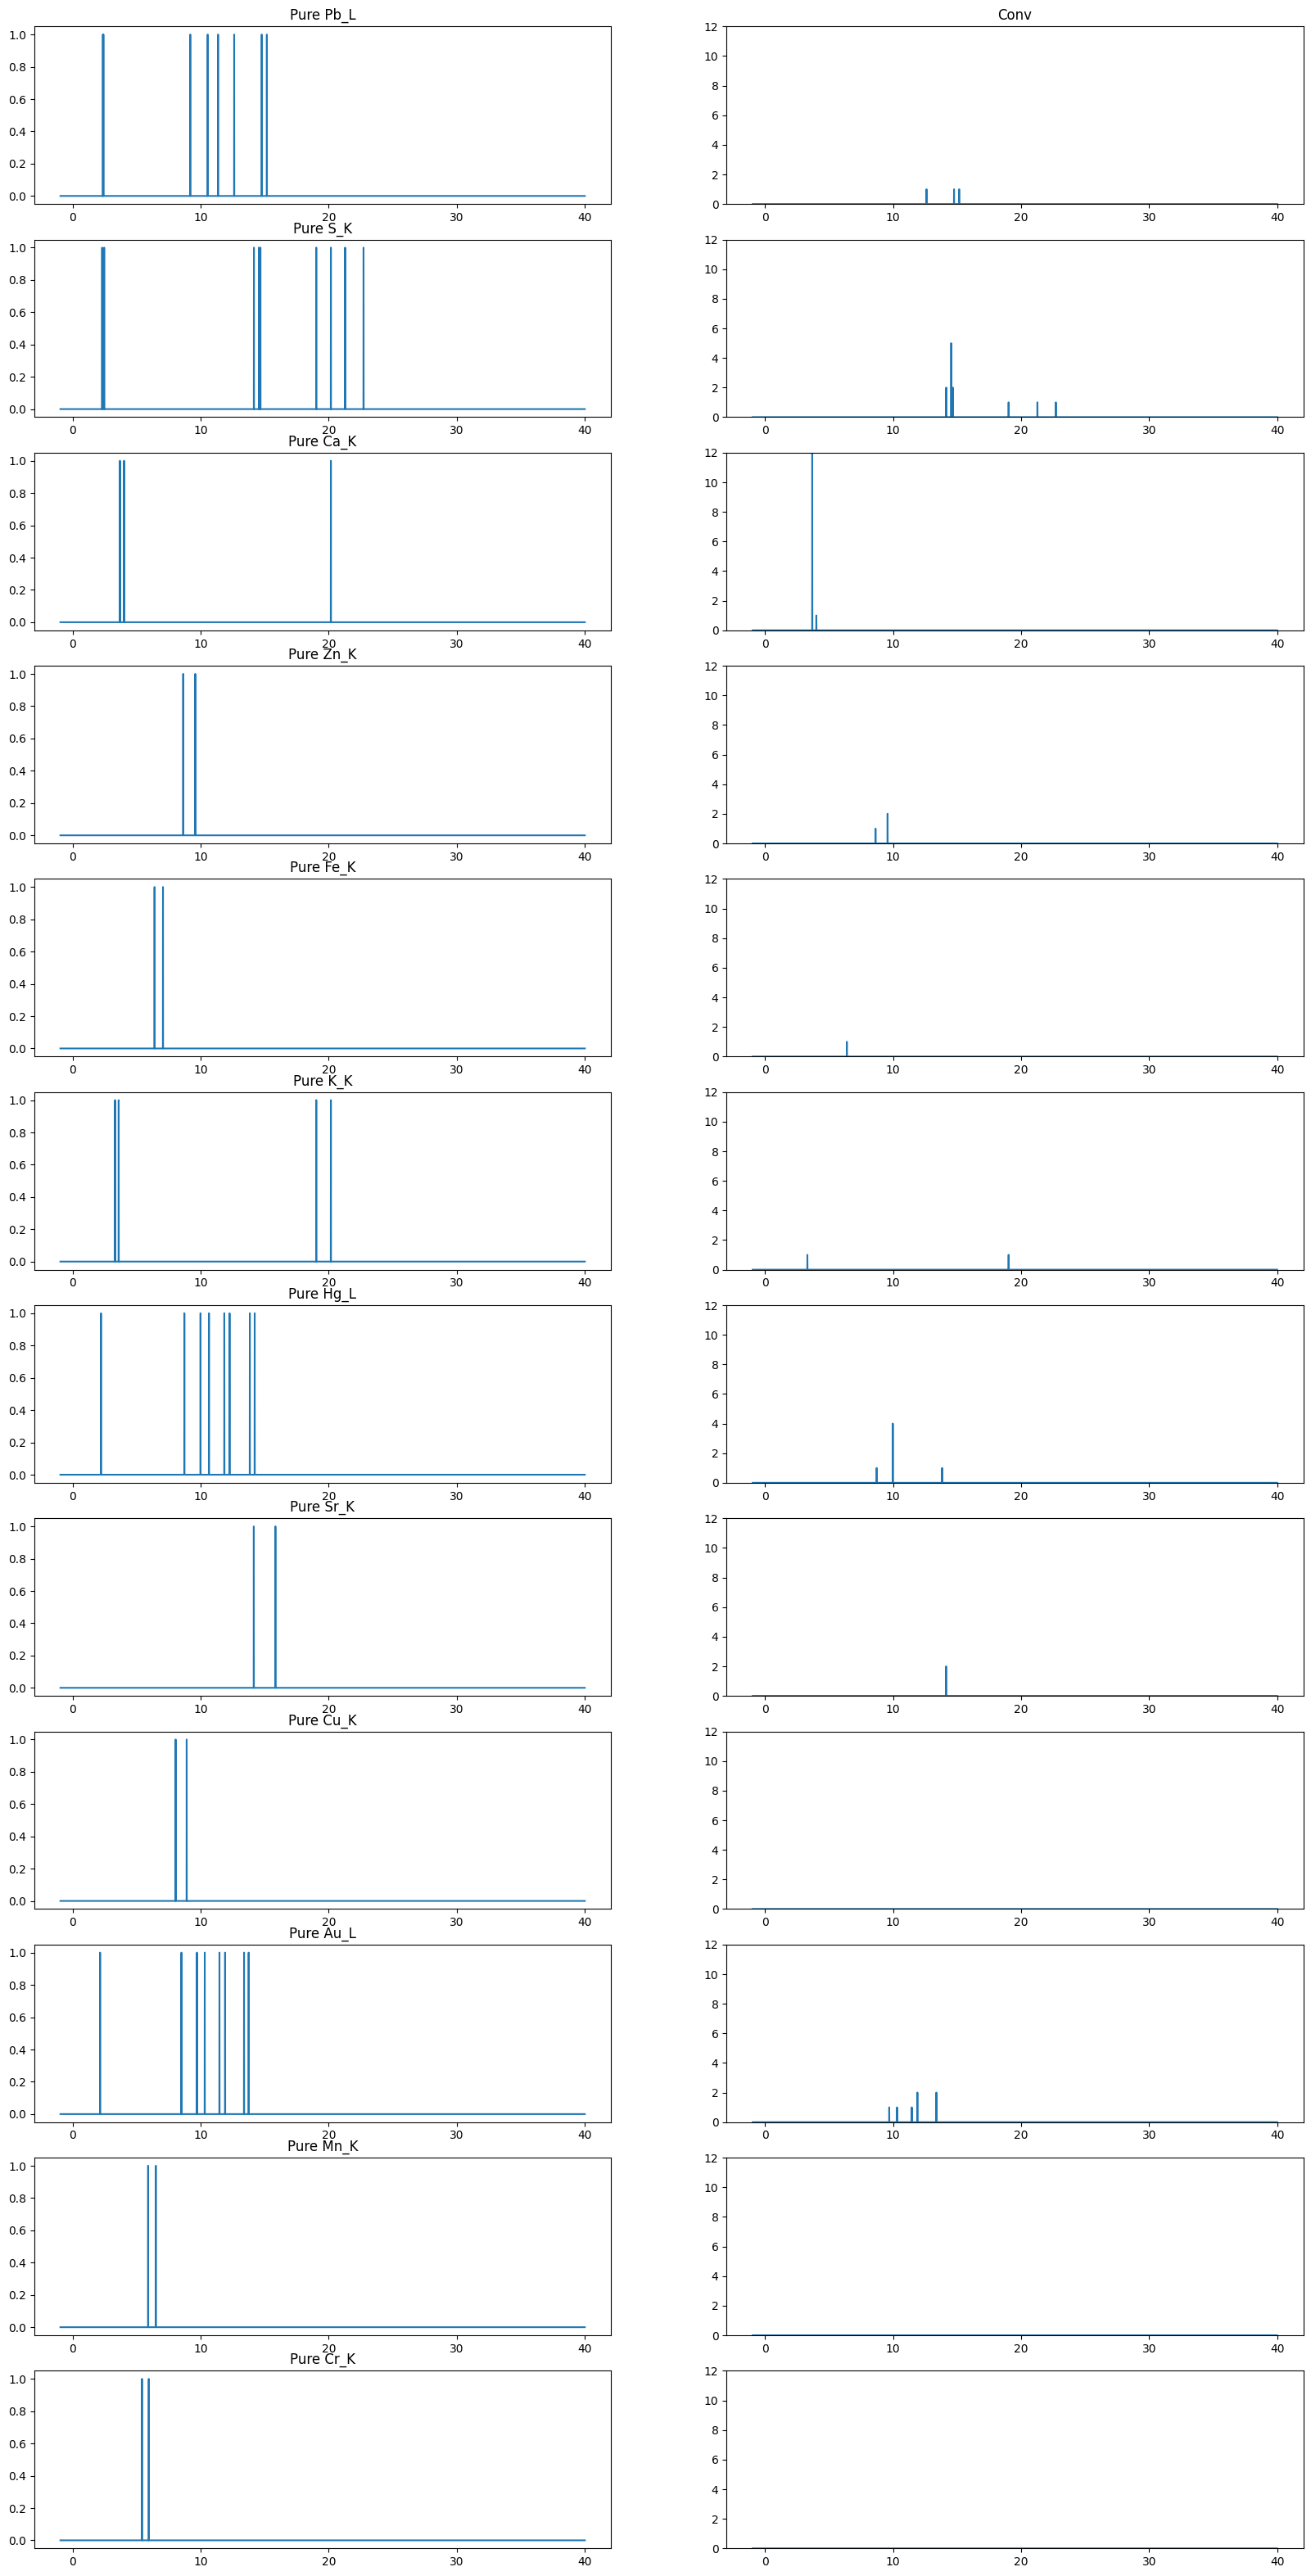

In [35]:
import torch
import torch.nn.functional as F
from scipy.signal import find_peaks

threshold = 0.01  # Adjust the threshold value as needed

spectrum = dataset.X[12511]
spectrum = spectrum.squeeze().cpu().numpy()
plt.figure(figsize=(20, 5))
plt.plot(e[0:4096], spectrum[0:4096])
plt.show()

norm_pure_elements = {}

target = dataset.y[12511]
# zip the target elements with the target values 
# and sor them by the target values
# print(list(zip(dataset.target_elems, target)))
print( sorted(zip(dataset.target_elems, target), key=lambda x: x[1], reverse=True) )

max_y = -1
fig, axes = plt.subplots(len(pure_elements), 2, figsize=(20, 40))
# iterate over all pure elements
for el_idx, element in enumerate(pure_elements):
    # get the pure element spectrum
    pure_spectrum = pure_elements[element]
    pure_spectrum = np.array([0 if x < threshold else x for x in pure_spectrum])
    peaks, _ = find_peaks(pure_spectrum, height=threshold)
    # set the other values to 0
    n_pure_spectrum = np.zeros_like(pure_spectrum)
    n_pure_spectrum[peaks] = pure_spectrum[peaks]
    norm_pure_elements[element] = n_pure_spectrum
    pure_spectrum = n_pure_spectrum

    # compute the conv with the spectrum
    # conv_spectrum = np.convolve(spectrum, pure_spectrum, mode='same')
    conv_spectrum = np.array([ spectrum[i] * pure_spectrum[i] for i in range(len(spectrum))])
    # plot the pure element spectrum
    axes[el_idx, 0].plot(e[0:4096], pure_spectrum[0:4096])
    axes[el_idx, 0].set_title(f'Pure {element}')
    # plot the convolved spectrum
    axes[el_idx, 1].plot(e[0:4096], conv_spectrum[0:4096])
    if el_idx == 0: axes[el_idx, 1].set_title('Conv')  

    #Set the y-axis limits for the second column subplots
    max_y = max(max_y, np.max(conv_spectrum))

for el_idx, element in enumerate(pure_elements):
    axes[el_idx, 1].set_ylim([0, max_y])

plt.show()

In [25]:
image_filename = "/home/igeor/MSC-THESIS/data/h5/spec/minos.hdf5"
import h5py
import pandas as pd 

## Open spectral image file
f = h5py.File(image_filename, 'r')
spec_image = f['Experiments/__unnamed__/data'][()] # numpy.ndarray 
f.close()

## Open target image file (elemental_maps)
target_file = image_filename.replace("spec", "elem_maps")
target_file = target_file.replace("hdf5", "dat")
df = pd.read_csv(target_file, sep='  ', engine='python')
target_image = np.array(df[dataset.target_elems])

target_image = target_image.reshape(
    spec_image.shape[0], spec_image.shape[1], len(dataset.target_elems)
)

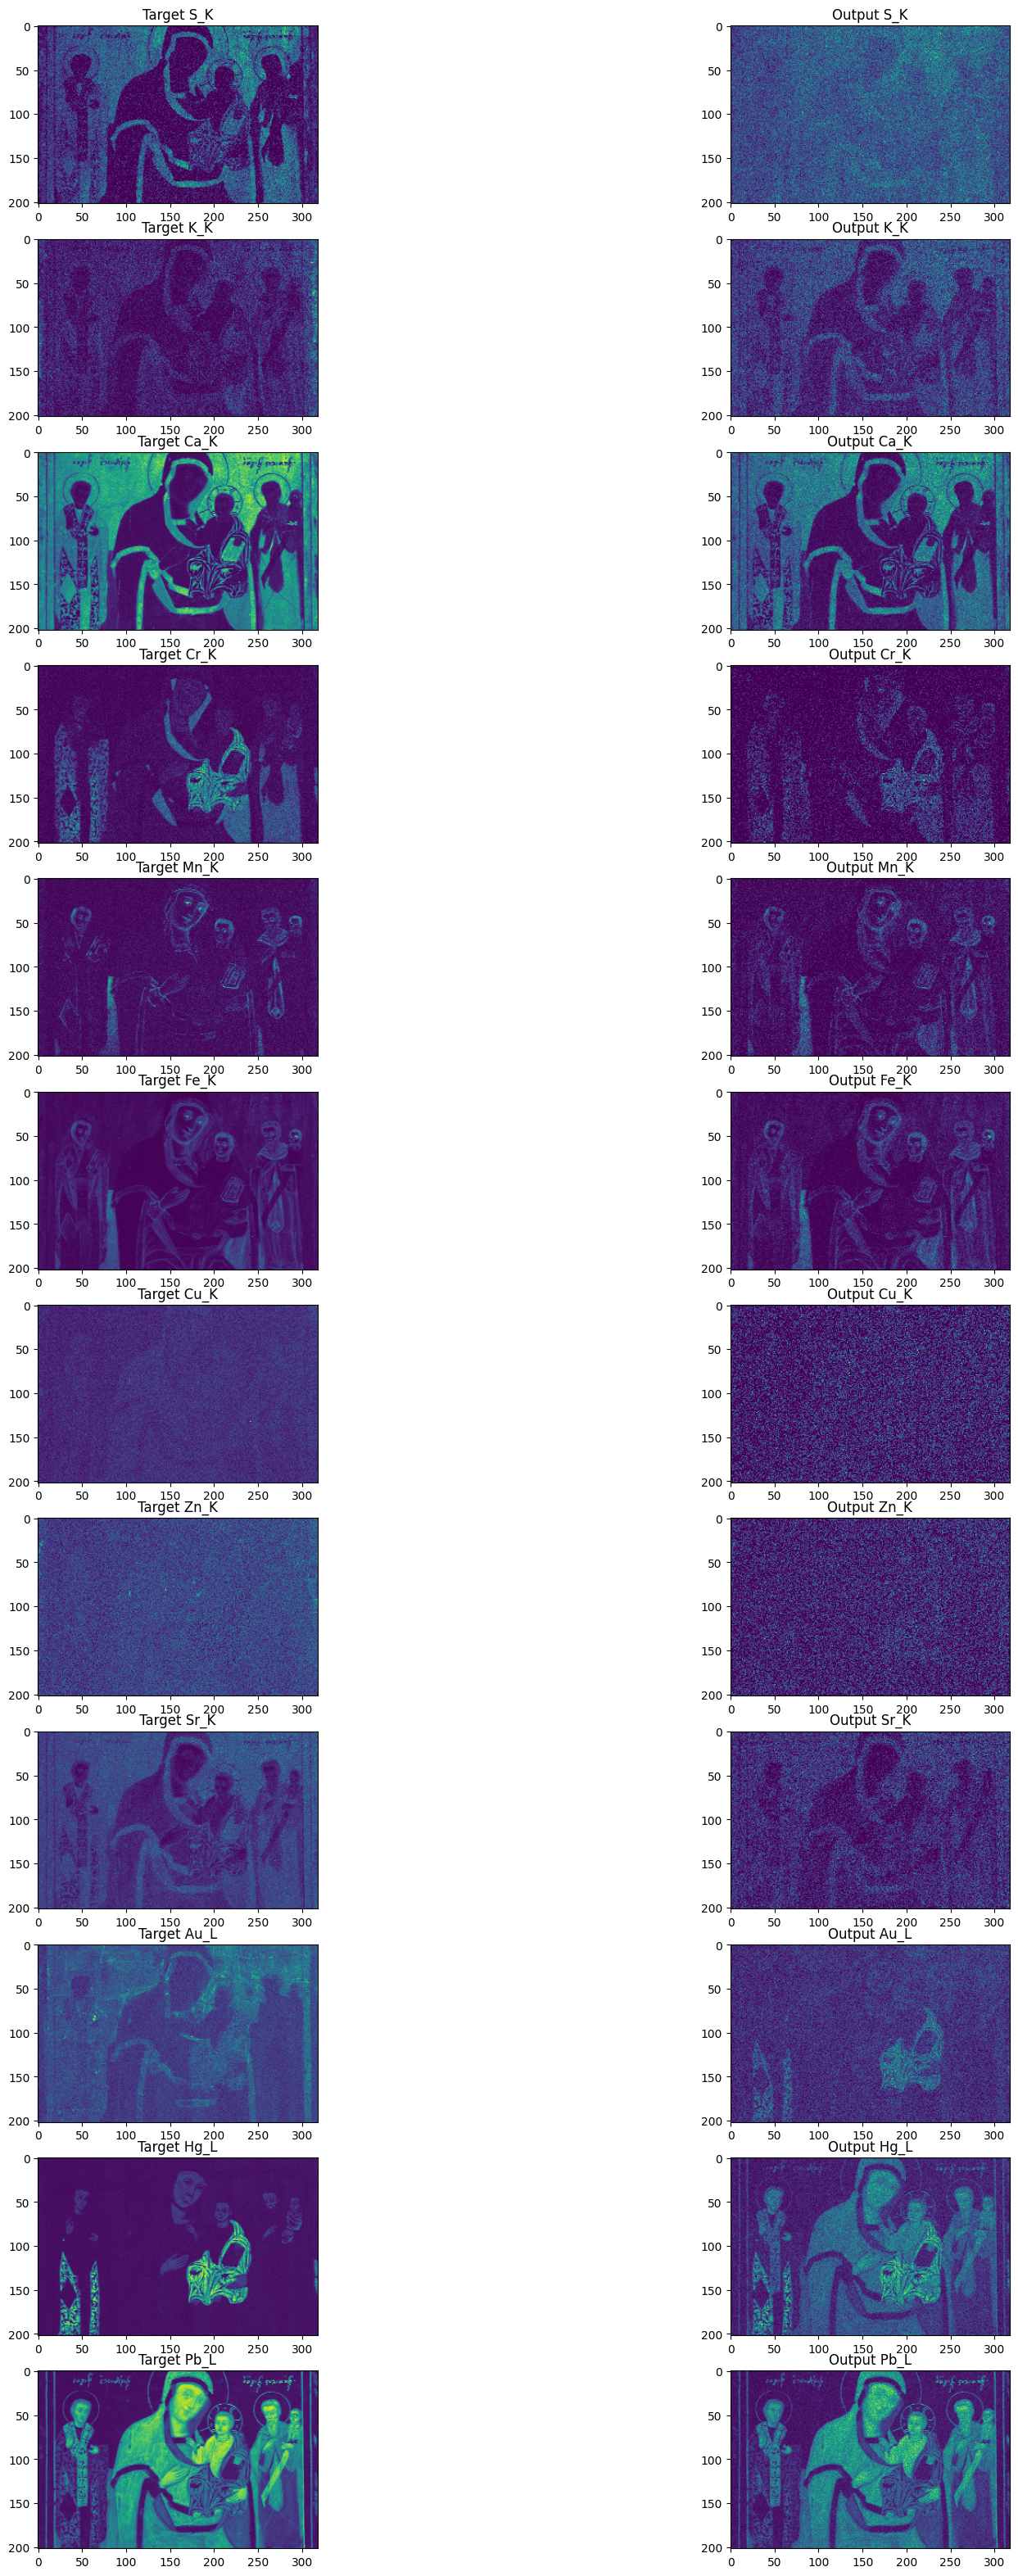

In [36]:
output_image = np.zeros((spec_image.shape[0], spec_image.shape[1], len(dataset.target_elems)))

# iterate over all pixels in the image
for i in range(spec_image.shape[0]):
    for j in range(spec_image.shape[1]):
        for el_idx, element in enumerate(dataset.target_elems):
            spectrum = spec_image[i, j]
            # get the pure element spectrum
            pure_spectrum = norm_pure_elements[element]
            output_image[i, j, el_idx] = np.dot(spectrum, pure_spectrum)


# subfigure all pure elements of output image
fig, axes = plt.subplots(len(dataset.target_elems), 2,  figsize=(20, 40))
for el_idx, element in enumerate(dataset.target_elems):
    axes[el_idx, 0].imshow(target_image[:, :, el_idx])
    axes[el_idx, 0].set_title(f'Target {element}')
    axes[el_idx, 1].imshow(output_image[:, :, el_idx])
    axes[el_idx, 1].set_title(f'Output {element}')